In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

In [5]:
df = pd.read_csv("disease_features.csv")
encoded_df = pd.read_csv("encoded_output2.csv")


In [6]:
import ast
def parse_and_join(text):
    lst = ast.literal_eval(text)
    return " ".join(lst)


In [7]:
for col in ["Risk Factors", "Symptoms", "Signs"]:
    df[col] = df[col].apply(parse_and_join)


In [8]:
tfidf_rf = TfidfVectorizer()
tfidf_symptoms = TfidfVectorizer()
tfidf_signs = TfidfVectorizer()

matrix_rf = tfidf_rf.fit_transform(df["Risk Factors"])
matrix_symptoms = tfidf_symptoms.fit_transform(df["Symptoms"])
matrix_signs = tfidf_signs.fit_transform(df["Signs"])


In [9]:
from scipy.sparse import hstack
tfidf_matrix = hstack([matrix_rf, matrix_symptoms, matrix_signs])


In [10]:
from scipy.sparse import csr_matrix
import numpy as np

def sparsity(matrix):
    return 1.0 - (matrix.nnz / float(matrix.shape[0] * matrix.shape[1]))

sparsity_tfidf = sparsity(tfidf_matrix)
onehot_numeric = encoded_df.apply(pd.to_numeric, errors="coerce").fillna(0).values.astype(float)
onehot_sparse = csr_matrix(onehot_numeric)
sparsity_onehot = sparsity(onehot_sparse)

features_tfidf = tfidf_matrix.shape[1]
features_onehot = encoded_df.shape[1]

print("TF-IDF sparsity:", sparsity_tfidf)
print("One-hot sparsity:", sparsity_onehot)
print("TF-IDF unique features:", features_tfidf)
print("One-hot unique features:", features_onehot)


TF-IDF sparsity: 0.9296078431372549
One-hot sparsity: 0.9534808853118713
TF-IDF unique features: 1020
One-hot unique features: 497


In [36]:
import pandas as pd
import ast
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from scipy.sparse import hstack, csr_matrix
import matplotlib.pyplot as plt

tfidf_dense = tfidf_matrix.toarray()
pca_tfidf = PCA(n_components=2)
tfidf_pca = pca_tfidf.fit_transform(tfidf_dense)
print("TF-IDF PCA EVR:", pca_tfidf.explained_variance_ratio_)

svd_tfidf = TruncatedSVD(n_components=2)
tfidf_svd = svd_tfidf.fit_transform(tfidf_matrix)
print("TF-IDF TruncatedSVD EVR:", svd_tfidf.explained_variance_ratio_)


TF-IDF PCA EVR: [0.06582989 0.05894907]
TF-IDF TruncatedSVD EVR: [0.00885917 0.06575207]


In [26]:
import pandas as pd
import ast
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from scipy.sparse import hstack, csr_matrix
import matplotlib.pyplot as plt

pca_onehot = PCA(n_components=2)
onehot_pca = pca_onehot.fit_transform(onehot_numeric)
print("One-hot PCA EVR:", pca_onehot.explained_variance_ratio_)

svd_onehot = TruncatedSVD(n_components=2)
onehot_svd = svd_onehot.fit_transform(onehot_sparse)
print("One-hot TruncatedSVD EVR:", svd_onehot.explained_variance_ratio_)


One-hot PCA EVR: [0.10538866 0.09170854]
One-hot TruncatedSVD EVR: [0.02247782 0.09195012]


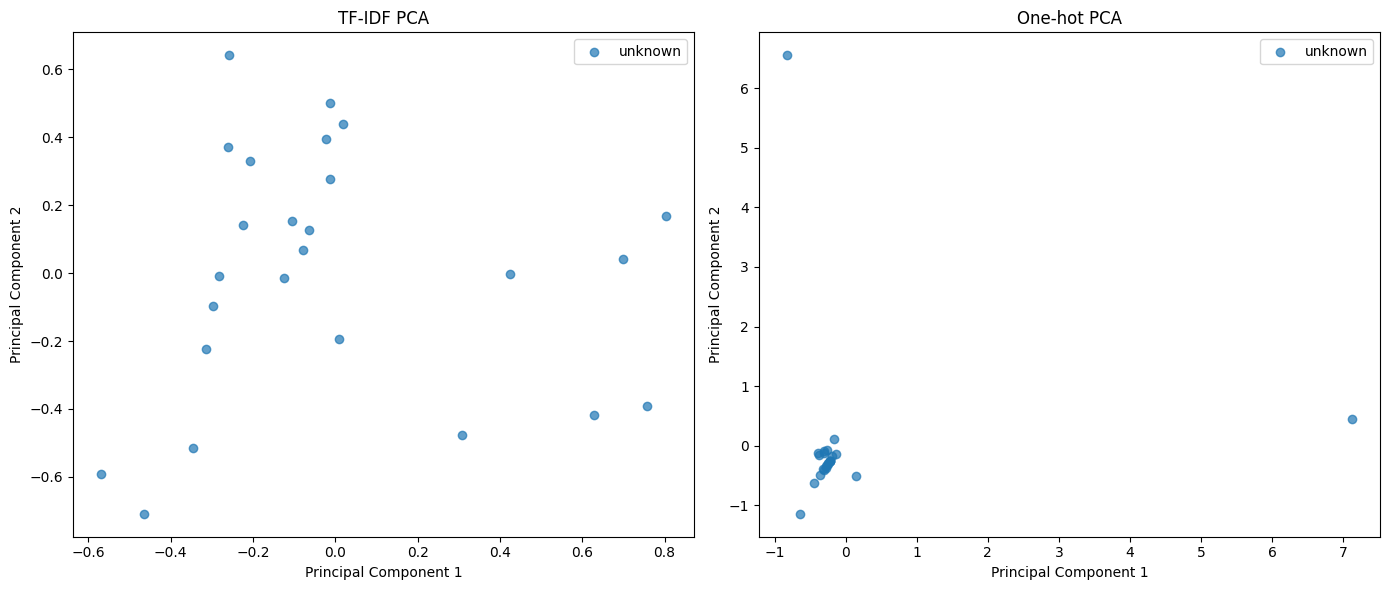

In [40]:
# %%
if "Category" in df.columns:
    labels = df["Category"]
elif "Subtype" in df.columns:
    labels = df["Subtype"]
else:
    labels = pd.Series(["unknown"] * df.shape[0])
unique_labels = labels.unique()
colors = {lab: plt.cm.tab10(i) for i, lab in enumerate(unique_labels)}

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
for lab in unique_labels:
    idx = labels == lab
    plt.scatter(tfidf_pca[idx, 0], tfidf_pca[idx, 1], label=lab, color=colors[lab], alpha=0.7)
plt.title("TF-IDF PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()

plt.subplot(1, 2, 2)
for lab in unique_labels:
    idx = labels == lab
    plt.scatter(onehot_pca[idx, 0], onehot_pca[idx, 1], label=lab, color=colors[lab], alpha=0.7)
plt.title("One-hot PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()

plt.tight_layout()
plt.show()


### Discussion

### Explained Variance Ratio: 
The printed explained variance ratios for PCA and TruncatedSVD indicate how much of the original data variance is captured in the first two components. Comparing these ratios between the TF-IDF and one-hot encoded matrices provides insight into which method preserves more information in the reduced space.

### Visualization and Cluster Separability:  
-> The TF-IDF encoding typically produces a high-dimensional space with weighted features reflecting term importance. When reduced to 2D, the clusters from TF-IDF often show distinct separability if the underlying text data varies significantly across disease categories.  
-> One-hot encoding, by contrast, represents each feature as a binary value, which may result in fewer, more sparse features. The separability of clusters in the one-hot PCA plot will depend on whether the categorical distinctions are well captured by the encoding.

Overall, if the clusters in the TF-IDF PCA plot exhibit clearer separations and higher explained variance in the first two components compared to the one-hot PCA plot, then TF-IDF is likely capturing more meaningful differences between disease categories.
